<a href="https://colab.research.google.com/github/userfromdarkside/ML-Projects/blob/main/Churn_Predi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

link dataset: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
df = df.copy()

In [ ]:
df = df.drop(columns=['customerID'])

In [ ]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')

In [ ]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [ ]:
df.isnull().sum()

,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [ ]:
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'),StandardScaler())

In [ ]:
num_cols = df.select_dtypes(include=['float64','int64']).columns.tolist()
num_cols

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']

In [ ]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [ ]:
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())

In [ ]:
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))

In [ ]:
preprocessing = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

Or I can build a preprocessing model with a simpler way:

In [ ]:
from sklearn.compose import make_column_selector, make_column_transformer
preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include='number')),
    (cat_pipeline, make_column_selector(dtype_include='object'))
)

In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size = 0.12, random_state=42)

In [ ]:
data = train_set.drop(columns=['Churn'])
data_labels = train_set['Churn'].copy()

In [ ]:
data_labels_churn = (data_labels == 1)

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg = make_pipeline(preprocessing, LogisticRegression())
log_reg.fit(data, data_labels)
model_score = log_reg.score(data, data_labels_churn)
print(model_score)

0.8042601258673552


In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = make_pipeline(preprocessing, DecisionTreeClassifier())
tree_clf.fit(data, data_labels)
model_score = tree_clf.score(data, data_labels_churn)
print(model_score)

0.9982249475552687


In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = make_pipeline(preprocessing, RandomForestClassifier())
forest_clf.fit(data, data_labels)
model_score = forest_clf.score(data, data_labels_churn)
print(model_score)

0.9982249475552687


In [ ]:
from sklearn.svm import SVC
svm_clf = make_pipeline(preprocessing, SVC())
svm_clf.fit(data, data_labels)
model_score = svm_clf.score(data, data_labels_churn)
print(model_score)

0.8168468613845409


Seem they work well on training set. For classification task, instead of using cross-validation, the much better way is using confused matrix.


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
data_labels_pred = cross_val_predict(forest_clf, data, data_labels_churn, cv=3)
confusion_matrix(data_labels_churn, data_labels_pred)

array([[4087,  470],
       [ 882,  758]])

In [ ]:
# pretend I reach the perfect model
data_labels_pred_f = data_labels_churn
confusion_matrix(data_labels_churn, data_labels_pred_f)

array([[4557,    0],
       [   0, 1640]])

Precision & Recall

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision_score(data_labels_churn, data_labels_pred)

0.6172638436482085

In [ ]:
recall_score(data_labels_churn, data_labels_pred)

0.46219512195121953

I also have F1 score

In [ ]:
from sklearn.metrics import f1_score
f1_score(data_labels_churn, data_labels_pred)

0.5285913528591354

Because the dataset is imbalanced (churn class is much rarer than another). So I should use PR curve rather than ROC curve

In [ ]:
y_scores = cross_val_predict(svm_clf, data, data_labels_churn, cv=3,
                             method='decision_function')

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(data_labels_churn, y_scores )

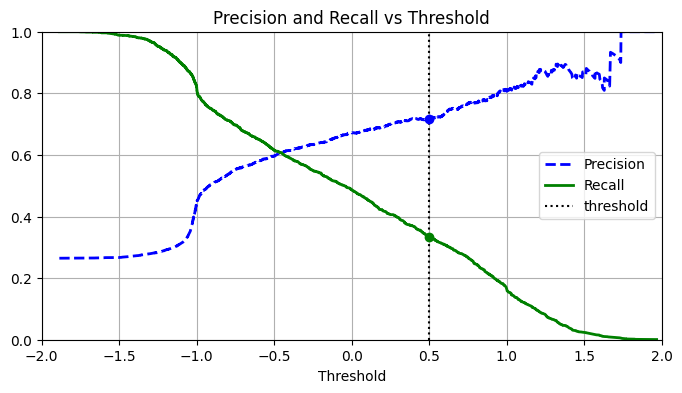

In [ ]:
# Plot the PR curve
threshold = 0.5 # assume we got the threshold value
from matplotlib import pyplot as plt
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-2, 2, 0, 0.5])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.ylim([0, 1])
plt.title("Precision and Recall vs Threshold")
plt.show()

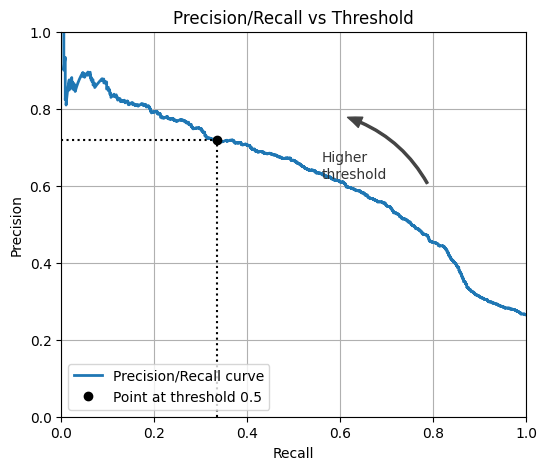

In [ ]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 0.5")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.title("Precision/Recall vs Threshold")

plt.show() # lol I will fix the narrow sign's location when I have time

In [ ]:
# Assume I want to get 70% of Precision. Let find the threshold value for it.
idx_for_70_precision = (precisions >= 0.7).argmax()
threshold_for_70_precision = thresholds[idx_for_70_precision]
threshold_for_70_precision

0.2513437461022857